In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as tfk
import tensorflow.keras.applications as tfa
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import json
import pickle
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import pandas as pd

# set seed (so that results can be reproduced)
seed = 42
np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default();
# print(creds.client_id)
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p /content/drive2
!google-drive-ocamlfuse /content/drive2

drive_dir = '/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/'


!ls /content/drive/MyDrive/

# Access GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Access more memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')


# # See if Tensorflow is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Mounted at /content/drive
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%

In [ ]:
folders = ['fold_0','fold_1','fold_2']
labels = ['all','hem']
img_size = 250
def get_data(data_dir):
    data = [] 
    for folder in folders :
      fold = os.path.join(data_dir, folder)
      for label in labels: 
          path = os.path.join(fold, label)
          class_num = labels.index(label)
          for img in os.listdir(path):
              try:
                  img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                  resized_arr = cv2.resize(img_arr, (img_size, img_size))
                  if(label=="hem"):
                    da1=cv2.rotate(resized_arr,cv2.ROTATE_90_CLOCKWISE)
                    data.append([da1, class_num])
                  data.append([resized_arr, class_num])
              except Exception as e:
                  print(e)
    return np.array(data)

In [ ]:
import cv2
tran_data = get_data(drive_dir)
np.random.shuffle(tran_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
x_train = []
y_train = []
for feature, label in tran_data:
  x_train.append(feature)
  y_train.append(label)

In [ ]:
print(len(x_train)) # number of image files
print(len(y_train)) # number of labels

print(np.sum(y_train)) # number of all files
print(len(y_train) - np.sum(y_train)) # number of hem files

# split data into train and validation sets
train_x_files, val_x_files, train_y, val_y = train_test_split(
    x_train, y_train, test_size = 0.3, random_state=seed, shuffle=True)
val_x_files, test_x_files, val_y, test_y = train_test_split(
    val_x_files, val_y, test_size = 0.5, random_state=seed, shuffle=True)

# train/val/test split is 60/20/20
print(f"Number of files in training set: {len(train_x_files)}") # number of files in training set
print(f"Number of files in validation set: {len(val_x_files)}") # number of files in validation set
print(f"Number of files in test set: {len(test_x_files)}") # number of files in test set

14048
14048
6776
7272
Number of files in training set: 9833
Number of files in validation set: 2107
Number of files in test set: 2108


In [ ]:
np.save(drive_dir+"test_omar_opp_da4/"+"train_x_files.npy",train_x_files)
np.save(drive_dir+"test_omar_opp_da4/"+"train_y.npy",train_y)
np.save(drive_dir+"test_omar_opp_da4/"+"val_x_files.npy",val_x_files)
np.save(drive_dir+"test_omar_opp_da4/"+"val_y.npy",val_y)

np.save(drive_dir+"test_omar_opp_da4/"+"test_x_files.npy",test_x_files)
np.save(drive_dir+"test_omar_opp_da4/"+"test_y.npy",test_y)

In [ ]:
# images are 450x450 (with 3 channels for RGB)
nx = 250
nh = 250
nc = 3
img_shape = (nx, nh, nc)
batch_size = 32

In [ ]:
# Loads batch of images from files
class ImageGenerator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_files, labels, batch_size, mean, std, img_shape=img_shape) :
    self.x = image_files
    self.y = labels
    self.batch_size = batch_size
    self.mean = mean
    self.std = std
    self.img_shape = img_shape
    
    
  def __len__(self) :
    return (np.ceil(len(self.x)/float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, i, preprocess=True) :
    batch_x = self.x[i*self.batch_size : (i+1)*self.batch_size]
    batch_y = self.y[i*self.batch_size : (i+1)*self.batch_size]
    
    if preprocess:
      return (np.array([
           resize((file-self.mean)/self.std, self.img_shape) for file in batch_x])), np.array(batch_y)    
    else:
      return np.array([
            resize(file, self.img_shape) for file in batch_x]), np.array(batch_y)

In [ ]:
train_gen =  ImageGenerator(train_x_files, train_y, batch_size, 9.854626920021918, 24.502705188655078) # image generator for training set
val_gen = ImageGenerator(val_x_files, val_y, batch_size, 9.854626920021918, 24.502705188655078) # image generator for validation set
#test_gen = ImageGenerator(test_x_files, test_y, batch_size, 9.854626920021918, 24.502705188655078) # image generator for test set

In [ ]:
class_names = ['all','hem'] # names of classes

In [ ]:
def display_images_and_labels(image_gen, i=0, n_images=min(batch_size, 10), preprocess=False):
  images, labels = image_gen.__getitem__(i, preprocess)
  plt.figure(figsize=(50, 50))
  for j in range(n_images):
        ax = plt.subplot(10, 10, j + 1)
        plt.imshow(images[j])
        plt.title(class_names[labels[j]])
        plt.axis("off")

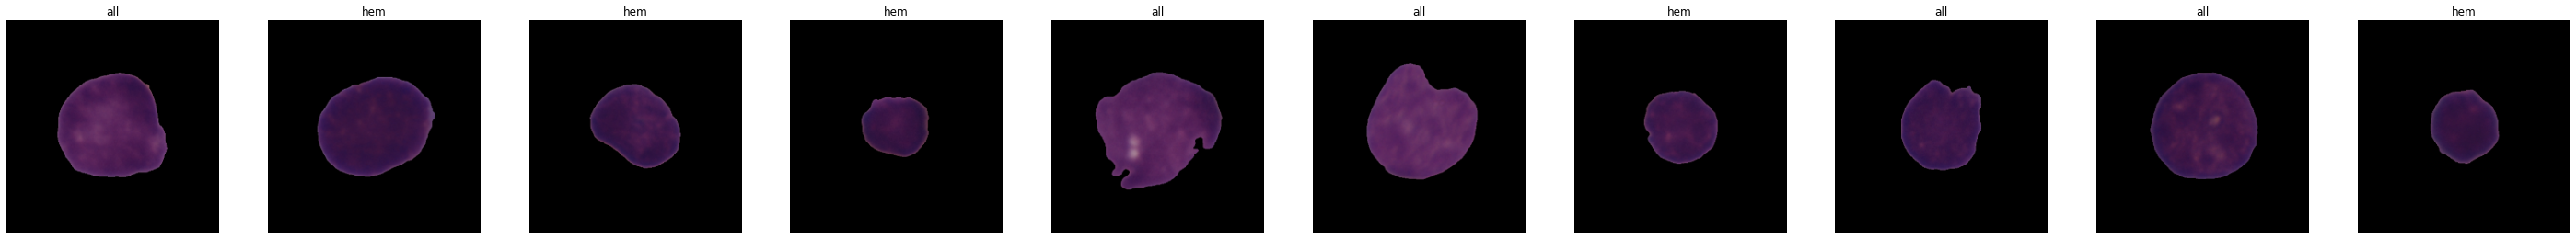

In [ ]:
display_images_and_labels(train_gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

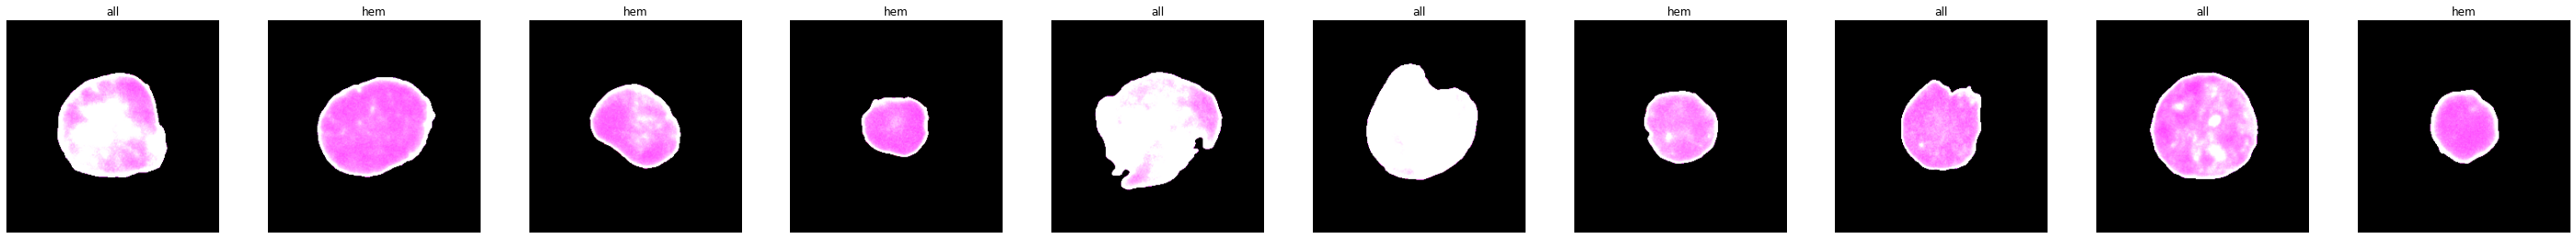

In [ ]:
display_images_and_labels(train_gen, preprocess=True) # preprocessed images

In [ ]:
epochs = 40
def checkpoint(name):
  return [tfk.callbacks.ModelCheckpoint(name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
#class_weight = {0: np.sum(train_y)/(len(train_y) - np.sum(train_y)),
     #           1: 1.0}
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(y_train),y = y_train)
class_weights = {0: 0.96589659,1: 1.03659976}
class_weights

{0: 0.96589659, 1: 1.03659976}

In [ ]:
def get_model(img_shape=img_shape, num_xception_layers_freeze=40, num_vgg_layers_freeze=10, num_inception_layers_freeze=260, loss_function='binary_crossentropy', metrics='accuracy', lr=0.001):
  input = tfk.Input(shape=img_shape)

  inceptionv3 = tfa.InceptionV3(input_tensor=input, weights='imagenet', include_top=False)
  xception = tfa.Xception(input_tensor=input, weights='imagenet', include_top=False)
  vgg16 = tfa.VGG16(input_tensor=input, weights='imagenet', include_top=False)
  
  for i in range(num_inception_layers_freeze):
    inceptionv3.layers[i].traiable = False

  for i in range(num_xception_layers_freeze):
    xception.layers[i].trainable = False
    xception.layers[i]._name = xception.layers[i]._name + '_xception'

  for i in range(num_vgg_layers_freeze):
    vgg16.layers[i].trainable = False
    vgg16.layers[i]._name = vgg16.layers[i]._name + '_vgg16_1'

      
  xception_conv1 = tfl.Conv2D(1024, kernel_size=1, strides=1, activation='relu', name='xception_conv1')(xception.output)
  xception_conv2 = tfl.Conv2D(2048, kernel_size=2, strides=1, activation='relu', name='xception_conv2')(xception_conv1)
  xception_norm1 = tfl.BatchNormalization()(xception_conv2)
  xception_padding = tfl.ZeroPadding2D()(xception_norm1)
  xception_pool = tfl.MaxPooling2D(pool_size=2, strides=2, name='xception_pool')(xception_padding)

  inception_conv1 = tfl.Conv2D(2048, kernel_size=2, strides=1, activation='relu', name='inception_conv1')(inceptionv3.output)
  inception_conv2 = tfl.Conv2D(2048, kernel_size=2, strides=1, activation='relu', name='inception_conv2')(inception_conv1)
  inception_conv3 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='inception_conv3')(inception_conv2)
  inception_norm = tfl.BatchNormalization()(inception_conv3)

  vgg_conv1 = tfl.Conv2D(1024, kernel_size=1, strides=1, activation='relu', name='vgg_conv1')(vgg16.output)
  vgg_conv2 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='vgg_conv2')(vgg_conv1)
  vgg_padding = tfl.ZeroPadding2D()(vgg_conv2)
  vgg_pool = tfl.MaxPooling2D(pool_size=2, strides=2, name='vgg_pool')(vgg_padding)

  inception_midlayer_1 = inceptionv3.layers[17].output
  inception_midlayer_2 = inceptionv3.get_layer('mixed5').output

  inception_midlayer_1_pool = tfl.MaxPooling2D(pool_size=2, strides=2, name='inception_midlayer_1_pool')(inception_midlayer_1)
  inception_midlayer_1_conv1 = tfl.Conv2D(1024, kernel_size=2, strides=2, activation='relu', name='inception_midlayer_1_conv1')(inception_midlayer_1_pool)
  inception_midlayer_1_conv2 = tfl.Conv2D(2048, kernel_size=1, strides=2, activation='relu', name='inception_midlayer_1_conv2')(inception_midlayer_1_conv1)
  inception_midlayer_1_norm = tfl.BatchNormalization()(inception_midlayer_1_conv2)

  inception_midlayer_2_pool = tfl.MaxPooling2D(pool_size=2, strides=2, name='inception_midlayer_2_pool')(inception_midlayer_2)
  inception_midlayer_2_conv1 = tfl.Conv2D(1024, kernel_size=3, strides=1, activation='relu', name='inception_midlayer_2_conv1')(inception_midlayer_2_pool)
  inception_midlayer_2_conv2 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='inception_midlayer_2_conv2')(inception_midlayer_2_conv1)
  inception_midlayer_2_norm = tfl.BatchNormalization()(inception_midlayer_2_conv2)

  xception_midlayer_1 = xception.layers[10].output
  xception_midlayer_2 = xception.layers[30].output

  xception_midlayer_1_pool = tfl.MaxPooling2D(pool_size=8, strides=4, name='xception_midlayer_1_pool')(xception_midlayer_1)
  xception_midlayer_1_conv1 = tfl.Conv2D(512, kernel_size=2, strides=2, activation='relu', name='xception_midlayer_1_conv1')(xception_midlayer_1_pool)
  xception_midlayer_1_conv2 = tfl.Conv2D(1024, kernel_size=2, strides=2, activation='relu', name='xception_midlayer_1_conv2')(xception_midlayer_1_conv1)
  xception_midlayer_1_norm1 = tfl.BatchNormalization()(xception_midlayer_1_conv2)
  xception_midlayer_1_conv3 = tfl.Conv2D(2048, kernel_size=1, strides=2, activation='relu', name='xception_midlayer_1_conv3')(xception_midlayer_1_norm1)
  xception_midlayer_1_conv4 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='xception_midlayer_1_conv4')(xception_midlayer_1_conv3)
  xception_midlayer_1_norm = tfl.BatchNormalization()(xception_midlayer_1_conv4)

  xception_midlayer_2_pool = tfl.MaxPooling2D(pool_size=2, strides=2, name='xception_midlayer_2_pool')(xception_midlayer_2)
  xception_midlayer_2_conv1 = tfl.Conv2D(512, kernel_size=2, strides=2, activation='relu', name='xception_midlayer_2_conv1')(xception_midlayer_2_pool)
  xception_midlayer_2_padding = tfl.ZeroPadding2D()(xception_midlayer_2_conv1)
  xception_midlayer_2_conv2 = tfl.Conv2D(1024, kernel_size=2, strides=2, activation='relu', name='xception_midlayer_2_conv2')(xception_midlayer_2_padding)
  xception_midlayer_2_norm1 = tfl.BatchNormalization()(xception_midlayer_2_conv2)
  xception_midlayer_2_conv3 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='xception_midlayer_2_conv3')(xception_midlayer_2_norm1)
  xception_midlayer_2_conv4 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='xception_midlayer_2_conv4')(xception_midlayer_2_conv3)
  xception_midlayer_2_norm = tfl.BatchNormalization()(xception_midlayer_2_conv4)

  vgg_midlayer_1 = vgg16.get_layer('block1_pool_vgg16_1').output
  vgg_midlayer_2 = vgg16.get_layer('block3_pool').output

  vgg_midlayer_1_pool = tfl.MaxPooling2D(pool_size=8, strides=4, name='vgg_midlayer_1_pool')(vgg_midlayer_1)
  vgg_midlayer_1_conv1 = tfl.Conv2D(512, kernel_size=2, strides=2, activation='relu', name='vgg_midlayer_1_conv1')(vgg_midlayer_1_pool)
  vgg_midlayer_1_conv2 = tfl.Conv2D(1024, kernel_size=2, strides=2, activation='relu', name='vgg_midlayer_1_conv2')(vgg_midlayer_1_conv1)
  vgg_midlayer_1_norm = tfl.BatchNormalization()(vgg_midlayer_1_conv2)
  vgg_midlayer_1_conv3 = tfl.Conv2D(2048, kernel_size=1, strides=2, activation='relu', name='vgg_midlayer_1_conv3')(vgg_midlayer_1_norm)
  vgg_midlayer_1_conv4 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='vgg_midlayer_1_conv4')(vgg_midlayer_1_conv3)
  vgg_midlayer_1_norm_1 = tfl.BatchNormalization()(vgg_midlayer_1_conv4)

  vgg_midlayer_2_pool = tfl.MaxPooling2D(pool_size=2, strides=2, name='vgg_midlayer_2_pool')(vgg_midlayer_2)
  vgg_midlayer_2_conv1 = tfl.Conv2D(512, kernel_size=2, strides=2, activation='relu', name='vgg_midlayer_2_conv1')(vgg_midlayer_2_pool)
  vgg_midlayer_2_padding = tfl.ZeroPadding2D()(vgg_midlayer_2_conv1)
  vgg_midlayer_2_conv2 = tfl.Conv2D(1024, kernel_size=2, strides=2, activation='relu', name='vgg_midlayer_2_conv2')(vgg_midlayer_2_padding)
  vgg_midlayer_2_norm = tfl.BatchNormalization()(vgg_midlayer_2_conv2)
  vgg_midlayer_2_conv3 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='vgg_midlayer_2_conv3')(vgg_midlayer_2_norm)
  vgg_midlayer_2_conv4 = tfl.Conv2D(2048, kernel_size=1, strides=1, activation='relu', name='vgg_midlayer_2_conv4')(vgg_midlayer_2_conv3)
  vgg_midlayer_2_norm1 = tfl.BatchNormalization()(vgg_midlayer_2_conv4)

  concatenate1 = tfl.Concatenate(axis=-1, name='concatenate1')([vgg_midlayer_1_norm_1, vgg_midlayer_2_norm1,xception_midlayer_1_norm, xception_midlayer_2_norm, inception_midlayer_1_norm, inception_midlayer_2_norm])
  concatenate2 = tfl.Concatenate(axis=-1, name='concatenate2')([vgg_pool,xception_pool, inception_norm])

  concatenate1_conv1 = tfl.Conv2D(6144, kernel_size=1, strides=1, activation='relu', name='concatenate1_conv1')(concatenate1)
  concatenate1_conv2 = tfl.Conv2D(3072, kernel_size=1, strides=1, activation='relu', name='concatenate1_conv2')(concatenate1_conv1)

  concatenate3 = tfl.Concatenate(axis=-1, name='concatenate3')([concatenate2, concatenate1_conv2])

  pool = tfl.MaxPooling2D(pool_size=3, strides=2, name='pool')(concatenate3)
  conv = tfl.Conv2D(1024, kernel_size=1, strides=1, name='conv')(pool)
  flatten = tfl.Flatten()(conv)

  fc1 = tfl.Dense(1024, activation='relu', name='fc1')(flatten)
  fc2 = tfl.Dense(1024, activation='relu', name='fc2')(fc1)

  output = tfl.Dense(1, activation='sigmoid', name='output')(fc2)

  model = tfk.models.Model(input, output, name="Model")
  model.compile(optimizer=Adam(learning_rate=lr) , loss = loss_function, metrics = metrics)

  return model

In [ ]:
model = get_model()
print("Number of layers: " + str(len(model.layers)))
model.summary()
plot_model(model, to_file=drive_dir+"test_omar_opp_da4/"+'model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_history = model.fit(x=train_gen, epochs=epochs, validation_data=val_gen, callbacks=checkpoint(drive_dir+"test_omar_opp_da4/"+"Model"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Epoch 1/40
308/308 [==============================] - ETA: 0s - loss: 1.8229 - accuracy: 0.7986
Epoch 1: val_accuracy improved from -inf to 0.74324, saving model to /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model/assets
308/308 [==============================] - 296s 868ms/step - loss: 1.8229 - accuracy: 0.7986 - val_loss: 1.2871 - val_accuracy: 0.7432
Epoch 2/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.8714
Epoch 2: val_accuracy did not improve from 0.74324
308/308 [==============================] - 229s 743ms/step - loss: 0.3309 - accuracy: 0.8714 - val_loss: 2.5598 - val_accuracy: 0.5515
Epoch 3/40
308/308 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.8950
Epoch 3: val_accuracy did not improve from 0.74324
308/308 [==============================] - 234s 760ms/step - loss: 0.2746 - accuracy: 0.8950 - val_loss: 5.5746 - val_accuracy: 0.5145
Epoch 4/40
308/308 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9121
Epoch 4: val_accuracy improved from 0.74324 to 0.77029, saving model to /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model/assets
308/308 [==============================] - 26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9221
Epoch 5: val_accuracy improved from 0.77029 to 0.82582, saving model to /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model/assets
308/308 [==============================] - 262s 850ms/step - loss: 0.2010 - accuracy: 0.9221 - val_loss: 0.4711 - val_accuracy: 0.8258
Epoch 6/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9076
Epoch 6: val_accuracy improved from 0.82582 to 0.89511, saving model to /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model/assets
308/308 [==============================] - 261s 847ms/step - loss: 0.2497 - accuracy: 0.9076 - val_loss: 0.3468 - val_accuracy: 0.8951
Epoch 7/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9353
Epoch 7: val_accuracy did not improve from 0.89511
308/308 [==============================] - 230s 745ms/step - loss: 0.1671 - accuracy: 0.9353 - val_loss: 1.0603 - val_accuracy: 0.6806
Epoch 8/40
308/308 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9216
Epoch 8: val_accuracy did not improve from 0.89511
308/308 [==============================] - 234s 758ms/step - loss: 0.2273 - accuracy: 0.9216 - val_loss: 1.1959 - val_accuracy: 0.5980
Epoch 9/40
308/308 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9402
Epoch 9: val_accuracy improved from 0.89511 to 0.91457, saving model to /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/test_omar_opp_da4/Model/assets
308/308 [==============================] - 26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9609
Epoch 10: val_accuracy did not improve from 0.91457
308/308 [==============================] - 231s 748ms/step - loss: 0.1072 - accuracy: 0.9609 - val_loss: 1.5042 - val_accuracy: 0.7076
Epoch 11/40
308/308 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9528
Epoch 11: val_accuracy did not improve from 0.91457
308/308 [==============================] - 233s 756ms/step - loss: 0.1267 - accuracy: 0.9528 - val_loss: 1.6571 - val_accuracy: 0.7024
Epoch 12/40
308/308 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9558
Epoch 12: val_accuracy did not improve from 0.91457
308/308 [==============================] - 234s 758ms/step - loss: 0.1153 - accuracy: 0.9558 - val_loss: 4.3345 - val_accuracy: 0.5396
Epoch 13/40
308/308 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9668
Epoch 13: val_accuracy did not improve from 0.91457
308/308 [==

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8957
Epoch 17: val_accuracy did not improve from 0.93735
308/308 [==============================] - 228s 740ms/step - loss: 0.2990 - accuracy: 0.8957 - val_loss: 2.1200 - val_accuracy: 0.7019
Epoch 18/40
308/308 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.8988
Epoch 18: val_accuracy did not improve from 0.93735
308/308 [==============================] - 232s 754ms/step - loss: 0.2333 - accuracy: 0.8988 - val_loss: 0.4600 - val_accuracy: 0.8719
Epoch 19/40
308/308 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9398
Epoch 19: val_accuracy did not improve from 0.93735
308/308 [==============================] - 233s 755ms/step - loss: 0.1500 - accuracy: 0.9398 - val_loss: 0.3735 - val_accuracy: 0.8239
Epoch 20/40
308/308 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9744
Epoch 20: val_accuracy did not improve from 0.93735
308/308 [==

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9848
Epoch 22: val_accuracy did not improve from 0.94400
308/308 [==============================] - 229s 744ms/step - loss: 0.0496 - accuracy: 0.9848 - val_loss: 1.3046 - val_accuracy: 0.5771
Epoch 23/40
308/308 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9662
Epoch 23: val_accuracy did not improve from 0.94400
308/308 [==============================] - 233s 756ms/step - loss: 0.0897 - accuracy: 0.9662 - val_loss: 0.3529 - val_accuracy: 0.9222
Epoch 24/40
308/308 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9852
Epoch 24: val_accuracy did not improve from 0.94400
308/308 [==============================] - 233s 755ms/step - loss: 0.0445 - accuracy: 0.9852 - val_loss: 0.2968 - val_accuracy: 0.9131
Epoch 25/40
308/308 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9867
Epoch 25: val_accuracy did not improve from 0.94400
308/308 [==

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


308/308 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9847
Epoch 31: val_accuracy did not improve from 0.96583
308/308 [==============================] - 229s 742ms/step - loss: 0.0402 - accuracy: 0.9847 - val_loss: 1.9166 - val_accuracy: 0.7954
Epoch 32/40
308/308 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9915
Epoch 32: val_accuracy did not improve from 0.96583
308/308 [==============================] - 231s 750ms/step - loss: 0.0246 - accuracy: 0.9915 - val_loss: 0.2678 - val_accuracy: 0.9250
Epoch 33/40
308/308 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9777
Epoch 33: val_accuracy did not improve from 0.96583
308/308 [==============================] - 233s 757ms/step - loss: 0.0725 - accuracy: 0.9777 - val_loss: 0.2238 - val_accuracy: 0.9492
Epoch 34/40
308/308 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9932
Epoch 34: val_accuracy did not improve from 0.96583
308/308 [==